# Single-sat FAC estimation with Swarm

Adrian Blagau (Institute for Space Sciences, Bucharest) <br>
Joachim Vogt (Jacobs University Bremen) <br>
Version May. 2021

This notebook accompanies the article ["Multipoint Field-Aligned Current Estimates With Swarm"](https://doi.org/10.1029/2018JA026439) by A. Blagau, and J. Vogt, 2019. When used for publications, please acknowledge the authors' work by citing the paper.

**Introduction** The notebook implements the single-s/c method to compute the field-aligned current (FAC) and ionospheric radial current (IRC) densities on Swarm. The algorithm offers some advantages over the one used to generate the L2 product since (i) both low (LR) and high resolution (HR) L1b magnetic field data can be used, (ii) input data can be filtered by the user, and (iii) the inclination of FAC sheet can be taken into account provided that this information is known (e.g. as a result of applying the Minimum Variance Analysis).

While the algorithm is able to handle HR data, the presence of data gap (not marked in L1b files) could lead to unphysical results both for un-filtered and filtered analysis. In the LR files the missing data are marked by zero values on all magnetic field components; when such points occur within the analysis interval, the un-filtered analysis replaces them by NaN, prints the corresponding timestamps and prevents the analysis on filtered data.  

As input parameters (see the corresponding <a href="#input" style="color:green">section</a>), the user specifies the interval of analysis, the satellite, and the solicited resolution of magnetic field data. Optionally, the current sheet inclination can be specified in several ways (see below). The algorithm relies on CHAOS magnetic model(s) to compute the magnetic field perturbation, but the user can select another model available on the VirES platform. 

Importing useful libraries (numpy, pandas, matplotlib, ...)

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import datetime as dtm
import matplotlib.dates as mdt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Prepare to access ESA’s Swarm mission data and models from VirES environment

In [2]:
from viresclient import SwarmRequest

## Definition of convenience functions

In [3]:
def normvec(v):
    # Given an array of vectors v, the function returns 
    # the corresponding array of unit vectors
    return np.divide(v,np.linalg.norm(v,axis=-1).reshape(-1,1))

def rotvecax(v, ax, ang):
    # Rotates vector v by angle ang around a normal vector ax 
    # Uses Rodrigues' formula when v is normal to ax
    sa, ca = np.sin(np.deg2rad(ang)), np.cos(np.deg2rad(ang))
    return v*ca[...,np.newaxis] + np.cross(ax, v)*sa[...,np.newaxis]

def sign_ang(V, N, R):
    # returns the signed angle between vectors V and N, perpendicular 
    # to R; positive sign corresponds to right hand rule along R
    VxN = np.cross(V, N)
    pm = np.sign(np.sum(R*VxN, axis=-1))
    return np.degrees(np.arcsin(pm*np.linalg.norm(VxN, axis=-1)))       

Function *R_B_dB_in_GEOC* provides the (cartesian) position vector *R*, the magnetic field *B*, and the magnetic field perturbation *dB* in the GEOC frame.

In [4]:
def R_B_dB_in_GEOC(Rsph, Bnec, dBnec):
    latsc = np.deg2rad(Rsph[:,0])
    lonsc = np.deg2rad(Rsph[:,1])  
    radsc = 0.001*Rsph[:,2]
    # prepare conversion to global cartesian frame
    clt,slt = np.cos(latsc.flat),np.sin(latsc.flat)
    cln,sln = np.cos(lonsc.flat),np.sin(lonsc.flat)
    north = np.stack((-slt*cln,-slt*sln,clt),axis=-1)
    east = np.stack((-sln,cln,np.zeros(cln.shape)),axis=-1)
    center = np.stack((-clt*cln,-clt*sln,-slt),axis=-1)
    # store cartesian position vectors in position data matrix R
    R = -radsc[...,None]*center
    # store magnetic data in GEOC (same frame as for R)
    Bgeo = np.matmul(np.stack((north,east,center),axis=-1),
                        Bnec[...,None]).reshape(Bnec.shape)
    dBgeo = np.matmul(np.stack((north,east,center),axis=-1),
                        dBnec[...,None]).reshape(dBnec.shape)
    return R, Bgeo, dBgeo

Function *singleJfac* computes FAC and IRC densities, together with the corresponding error estimations, based on the single satellite method. Mandatory parameters are the satellite position *R*, magnetic field *B*, magnetic field perturbation *dB* (all arrays of vectors in GEOC), together with the corresponding timestamps *t*. \
The current sheet inclination (optional) can be specified with one of the parameters *alpha* (angle of inclination in the tangential plane wrt satellite velocity vector), *N2d* (projection of sheet normal on the tangential plane), or *N3d* (sheet normal in GEOC). For details see <a href="#input" style="color:green">Input parameters</a> section. The time-interval (optional) where the inclination is valid can be provided as well; if not, the information on inclination is assumed valid for the whole interval of analysis. \
The error in FAC and IRC densities are estimated based on the value of *er_db*, that specifies the error in magnetic field perturbation. The function also returns an array with FAC inclination in the tangential plane.

In [5]:
def singleJfac(t, R, B, dB, alpha=None, N2d=None, \
               N3d=None, tincl=None, er_db=0.5):
    # Construct the differences & values at mid-intervals
    dt = t[1:].values - t[:-1].values
    tmid = t[:-1].values + dt*0.5
    Bmid = 0.5*(B[1:,:] + B[:-1,:])           
    Rmid = 0.5*(R[1:,:] + R[:-1,:])
    diff_dB = dB[1:,:] - dB[:-1,:]    
    V3d = R[1:,:] - R[:-1,:]
    Vorb = np.sqrt(np.sum(V3d*V3d, axis=-1))      
    # Define important unit vectors
    eV3d, eBmid, eRmid = normvec(V3d), normvec(Bmid), normvec(Rmid)
    eV2d = normvec(np.cross(eRmid, np.cross(eV3d, eRmid)))    
    # Angle between B and R
    cos_b_r = np.sum(eBmid*eRmid, axis=-1)
    bad_ang = np.abs(cos_b_r) < np.cos(np.deg2rad(60))
 
    # incl is the array of FAC incliation wrt Vsat (in tangential plane)    
    if N3d is not None:
        eN3d = normvec(N3d)
        eN2d = normvec(eN3d - np.sum(eN3d*eRmid,axis=-1).reshape(-1,1)*eRmid)
        incl = sign_ang(eV2d, eN2d, eRmid)
    elif alpha is not None:
        incl = alpha if isinstance(alpha, np.ndarray) else \
                                     np.full(len(tmid), alpha)        
    elif N2d is not None:
        eN2d = normvec(np.cross(eRmid, np.cross(N2d, eRmid)))
        incl = sign_ang(eV2d, eN2d, eRmid)
    else:
        incl = np.zeros(len(tmid))

    # consider the validity interval of FAC inclination 
    if tincl is not None:
        ind_incl = np.where((tmid >= tincl[0]) & (tmid <= tincl[1]))[0]
        incl[0:ind_incl[0]] = incl[ind_incl[0]]
        incl[ind_incl[-1]:] = incl[ind_incl[-1]]

    # working in the tangential plane
    eNtang = normvec(rotvecax(eV2d, eRmid, incl))
    eEtang = normvec(np.cross(eNtang, eRmid))
    diff_dB_Etang = np.sum(diff_dB*eEtang, axis=-1)
    Dplane = np.sum(eNtang*eV2d, axis=-1)
    j_rad= - diff_dB_Etang/Dplane/Vorb/(4*np.pi*1e-7)*1.e-6
    j_rad_er= np.abs(er_db/Dplane/Vorb/(4*np.pi*1e-7)*1.e-6)   
    
    # FAC density and error
    j_b = j_rad/cos_b_r
    j_b_er = np.abs(j_rad_er/cos_b_r)    
    j_b[bad_ang] = np.nan
    j_b_er[bad_ang] = np.nan    
    
    return tmid, Rmid, j_b, j_rad, j_b_er, j_rad_er, incl, np.arccos(cos_b_r)*180./np.pi

Function that sets magnetic data gaps to NaN

In [6]:
def GapsAsNaN(df_ini, ind_gaps):
    df_out = df_ini.copy()
    df_out['B_NEC'][ind_gaps] = [np.full(3,np.NAN)]*len(ind_gaps)
    return df_out, df_ini.index[ind_gaps]

Function that provides the sampling step (needed in SwarmRequest) and the data sampling frequency (needed for data filtering) according to the magnetic data resolution

In [7]:
def rez_param(rez):
    sstep = 'PT1S' if rez=='LR' else 'PT0.019S'  # sampling step
    fs = 1 if rez=='LR' else 50   # data sampling freq.
    return sstep, fs

<a id='input'></a>
## Input parameters

Specify the time interval, satellite, data resolution, and magnetic field model.\
Optionally, the current sheet inclination can be specified by providing just one of the following parameters:
- *alpha* is the angle (in degree) of FAC inclination in the tangential plane wrt satellite velocity vector. The tangential plane is perpendicular to the satellite position vector. *alpha* can be a single value or series of values at mid-intervals, positive or negative according to the right-hand rotation along the position vector. Implicit value: None
- *N3d* is the FAC sheet normal in GEOC (three components vector). This is the usual output from MVA. Implicit value: None
- *N2d* is the projection of FAC sheet normal in the tangential plane (i.e. the GEOC components). It can be a vector or series of vectors at mid-intervals. Implicit value: None

The time interval when FAC inclination is to be considered can be specified in *tincl* (optional); outside this interval, the FAC inclination is assumed to take the values at the beginning/end of *tincl*. When *tincl* is not specified, the information on inclination is assumed valid for the whole interval of analysis 


In [8]:
dtime_beg = '2015-03-17T08:51:00'
dtime_end = '2015-03-17T08:58:00.1'

sat = ['C']

alpha, N3d, N2d, tincl = None, None, None, None
## Optional: FAC inclination
# alpha = -20. 
# N3d = [-0.32780841, 0.82644295, -0.45774851]
# N2d = [-0.326, 0.828, -0.457]
# tincl = np.array(['2015-03-17T08:51:54','2015-03-17T08:57:11'],dtype='datetime64')

rez = 'LR'          # 'LR' or 'HR' for low or high resolution data
use_filter = True   # 'True' for filtering the data

Bmodel="CHAOS-all='CHAOS-Core'+'CHAOS-Static'+'CHAOS-MMA-Primary'+'CHAOS-MMA-Secondary'"

## Data retrieval and preparation

Reads from VirES the sat. position (*Rsph*), magnetic L1b measurement (*Bnec*), and magnetic field model (*Bmod*). Auxiliary parameters *QDLat*, *QDLon*, and *MLT*, used when plotting the results, are retrieved as well. Computes the magnetic perturbation (in NEC) and filters it for later use.  

In [9]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAG"+sat[0]+"_"+rez+"_1B")
request.set_products(measurements=["B_NEC","Flags_B"], 
                         auxiliaries=['QDLat','QDLon','MLT'],
                         models=[Bmodel],
                         sampling_step=rez_param(rez)[0])
data = request.get_between(start_time = dtime_beg, 
                               end_time = dtime_end,
                               asynchronous=False)   
print('Used MAG L1B file: ', data.sources[1])
dat_df = data.as_dataframe()

# set missing B_NEC data (zero magnitude in L1b LR files) to NaN. 
# impose no filtering if there are missing data points.
ind_gaps = np.where(\
        np.linalg.norm(np.stack(dat_df['B_NEC'].values), axis = 1)==0)[0]
if len(ind_gaps):
    dat_df, timegaps = GapsAsNaN(dat_df, ind_gaps)
    print('NR. OF MISSING DATA POINTS: ', len(ind_gaps))
    print(timegaps.values)
    print('NO FILTERING IS PERFORMED')
    use_filter = False

ti = dat_df.index
nti = len(ti)
# store position, magnetic field and magnetic model vectors in corresponding data matrices
Rsph = dat_df[['Latitude','Longitude','Radius']].values
Bnec = np.stack(dat_df['B_NEC'].values, axis=0)
Bmod = np.stack(dat_df['B_NEC_CHAOS-all'].values, axis=0)  
dBnec = Bnec - Bmod
FlagsB = dat_df['Flags_B'].values

if use_filter:
    fc, butter_ord = 1/20, 5      # 20 s cutt-off freq., filter order
    bf, af = signal.butter(butter_ord, fc /(rez_param(rez)[1]/2), 'low')
    dBnec_flt = signal.filtfilt(bf, af, dBnec, axis=0)

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.101MB)

Used MAG L1B file:  SW_OPER_MAGC_LR_1B_20150317T000000_20150317T235959_0505_MDR_MAG_LR


Computes the (cartesian) position vector *R*, magnetic field *B*, and magnetic field perturbation *dB* in the GEOC frame. Compute FAC, IRC densities, and the corresponding estimation errors. Store quantities in DataFrame structures

In [10]:
R, B, dB = R_B_dB_in_GEOC(Rsph, Bnec, dBnec)
tt, Rmid, jb, jrad, jb_er, jrad_er, incl, ang_BR = \
    singleJfac(ti, R, B, dB, alpha=alpha, N2d=N2d, N3d=N3d, tincl=tincl)
j_df = pd.DataFrame(np.stack((Rmid[:,0], Rmid[:,1], Rmid[:,2], \
    jb, jrad, jb_er, jrad_er, ang_BR, incl)).transpose(),\
    columns=['Rmid X','Rmid_Y','Rmid Z','FAC','IRC','FAC_er','IRC_er','ang_BR','incl'], index=tt)
dB_df = pd.DataFrame(dB, columns=['dB Xgeo', 'dB Ygeo', 'dB Zgeo'], index=ti)
dB_nec_df = pd.DataFrame(dBnec, columns=['dB N', 'dB E', 'dB C'], index=ti)

Compute filtered FAC, IRC densities if data filtering is desired and possible. 

In [11]:
if use_filter:
    R, B, dB_flt = R_B_dB_in_GEOC(Rsph, Bnec, dBnec_flt)
    tt, Rmid, jb_flt, jrad_flt, jb_er_flt, jrad_er_flt, incl, ang_BR = \
        singleJfac(ti, R, B, dB_flt, alpha=alpha, N2d=N2d, N3d=N3d, tincl=tincl, er_db=0.2)
    jflt_df = pd.DataFrame(np.stack((Rmid[:,0], Rmid[:,1], Rmid[:,2],\
        jb_flt, jrad_flt, jb_er_flt, jrad_er_flt, ang_BR, incl)).transpose(),\
        columns=['Rmid X','Rmid_Y','Rmid Z','FAC_flt','IRC_flt',\
        'FAC_flt_er','IRC_flt_er','ang_BR','incl'], index=tt)    

Read the single-s/c FAC estimate from the L2 product for comparison

In [12]:
request.set_collection('SW_OPER_FAC'+sat[0]+'TMS_2F')
request.set_products(measurements=["FAC","IRC"], sampling_step="PT1S")
data = request.get_between(start_time = dtime_beg, 
                               end_time = dtime_end,
                               asynchronous=False)  
print('Used FAC file: ', data.sources[0])
FAC_L2 = data.as_dataframe()
FAC_L2.rename(columns={'FAC':"FAC_L2", 'IRC':"IRC_L2"}, inplace = True)


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.062MB)

Used FAC file:  SW_OPER_FACCTMS_2F_20150317T000000_20150317T235959_0301


Plot and save the current density data as ASCII file. Panel 1: magnetic field perturbation in GEOC, panel 2: un-filtered and (when applicable) filtered FAC, panel 3: un-filtered and (when applicable) filtered IRC, panel 4: comparison with FAC L2, panel 5: angle between *B* and *R* vectors, panel 6: considered angle between FAC normal and satellite velocity in the tangential plane. 

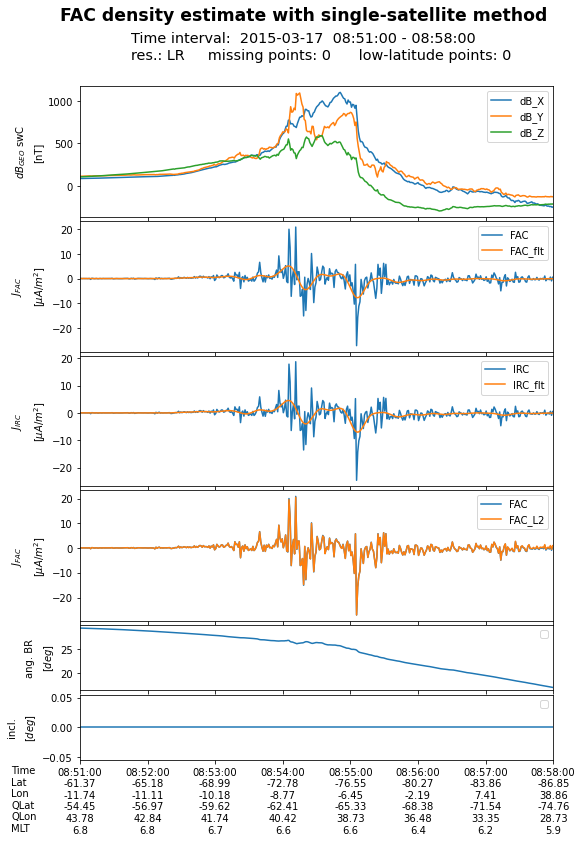

<Figure size 432x288 with 0 Axes>

In [13]:
%run -i "plot_and_save_single_sat.py"